In [1]:
# Boosted Decision Tree Data Analysis for AN-19-154

# Coders: Nathan Suri, Caltech
# Date: December 18, 2019
# LPC LLP Group

# Description
# Study shower shape to improve signal/bkg discrimination
# Implement established BDT procedure to data

# Notes/Conclusions
# @nasurijr: 

In [2]:
# User specifics
# Setups pwd location for data files and imports of special ROOT utilities

work_location = input("Username: ")
if work_location == 'nasurijr':
#     pwd = '/nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/'
    pwd = '/storage/user/nasurijr/gpu/nasurijr/LLP_analysis/delayed_jet_analyzer/'
    
    # Sets display width
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:85% !important; }</style>"))
else:
    print("Unrecognized username")
    
# elif work_location == '<Insert Tier2 username here>':
#     pwd = '/home/cms/delayed_jet_analyzer/'

Username:  nasurijr


# Imports

In [3]:
# Imports

import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import numpy as np
import pandas as pd
import math
import pickle as pickle
import ROOT as root
import os
import shlex
import uproot
import seaborn as sns

root.gROOT.SetBatch(True)
root.gStyle.SetOptStat(0)
root.gStyle.SetOptFit(111)
root.gStyle.SetPaintTextFormat("2.1f")

plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

test_name = 'xgb_wH_vs_WJetsToLNu_cscBDT'

lumi_sf_sig = 1.0 # scale lumi from sample to full run2
lumi_sf_bkg = 1.0

plotDir = pwd + 'plot_scripts/LLP_muon_system_studies/Test_scripts/'
dataDir = pwd + 'data/'

os.system("mkdir -p "+ plotDir)
os.system("mkdir -p "+ plotDir + "training")
os.system("mkdir -p "+ plotDir + "results")
os.system("mkdir -p "+ plotDir + "scores")
os.system("mkdir -p "+ plotDir + "variables")

Welcome to JupyROOT 6.18/02


0

# Load/Read Signal and Background Datafiles

In [4]:
#signal

# Normalized sample with no genLLP information stored
# signalFileName =  dataDir + 'WH_HToSSTobbbb_WToLNu_MH-125_MS-55_ctauS-10000_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root'

# WplusH sample with genLLP information stored
signalFileName = dataDir + 'ggH_HToSSTobbbb_ms55_pl1000_RunIIFall18_1pb_weighted.root'
signalFile = root.TFile(signalFileName)
signalTree = signalFile.Get('t')
signalHisto = root.gDirectory.Get('NEvents')
signalEvents = lumi_sf_sig*signalHisto.Integral()

#bkg
bkgFileName    = dataDir + 'Run2_displacedJetMuonNtupler_V1p12_Data2018_17Sept2018_Run2018-HighMET-17Sep2018_goodLumi.root'
bkgFile = root.TFile(bkgFileName)
bkgTree = bkgFile.Get('t')
bkgHisto = root.gDirectory.Get('NEvents')
bkgEvents = lumi_sf_bkg*bkgHisto.Integral()

print('[INFO]: S =' + str(signalEvents) + '; B =' + str(bkgEvents) +"; S/sqrt(B) = " + str(signalEvents/math.sqrt(bkgEvents)))

[INFO]: S =358800.0; B =9339111.0; S/sqrt(B) = 117.40853410932858


# Variable Definitions

## *Set of Variables excluding Matched Reco Object (Muon/Jet) Pt*

In [5]:
# Standard variable set removes redundant variables (excludes matched reco objects (objects used in vetoes i.e. muons/jets)

variables = [['cscRechitClusterXSpread', 'cscRechitClusterXSpread', '$\Delta x_{cluster}$', 100, 0, 120],
             ['cscRechitClusterYSpread', 'cscRechitClusterYSpread', '$\Delta y_{cluster}$', 100, 0, 120],
             ['cscRechitClusterZSpread', 'cscRechitClusterZSpread', '$\Delta z_{cluster}$', 100, 0, 120],
             ['cscRechitClusterTimeSpread', 'cscRechitClusterTimeSpread', '$\Delta t_{cluster}$', 150, -100, 100],
            ['cscRechitClusterEtaPhiSpread', 'cscRechitClusterEtaPhiSpread', '$\Delta \eta\times\phi_{cluster}$', 100, -4, -4],
            ['cscRechitClusterX', 'cscRechitClusterX', '$x_{cluster}$', 150, -1100, 1100],
            ['cscRechitClusterY', 'cscRechitClusterY', '$y_{cluster}$', 150, -1100, 1100],
            ['cscRechitClusterZ', 'cscRechitClusterZ', '$z_{cluster}$', 150, -1100, 1100]]
cluster_counts = [['nCscRechitClusters', 'nCscRechitClusters', '$N_{clusters}$', 5, 0, 5]]
llp_matching = [['cscRechitCluster_match_gLLP', 'cscRechitCluster_match_gLLP', 'llp_matching']]
llp_csc = [['gLLP_csc', 'gLLP_csc', 'llp_csc']]
cluster_size = [['cscRechitClusterSize', 'cscRechitClusterSize', '$N_{segments}', 150, 0, 250]]
cluster_time = [['cscRechitClusterTime', 'cscRechitClusterTime', 'ns', 150, -50, 50]]
jet_veto = [['cscRechitClusterJetVetoPt', 'cscRechitClusterJetVetoPt', '$p_{T, jet}$', 100, 0, 200]]
muon_veto = [['cscRechitClusterMuonVetoPt', 'cscRechitClusterMuonVetoPt', '$p_{T, muon}$', 150, 0, 200]]
ncsc = [['cscNRecHits', 'cscNRecHits', '$N_{rechits}$', 150, 0, 250]]

In [6]:
# Extracts the number of clusters per event for both signal and background

count_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in cluster_counts], flatten=False)
count_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in cluster_counts], flatten=False)

In [7]:
# Extracts the size of clusters per event for both signal and background

size_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in cluster_size], flatten=True)
size_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in cluster_size], flatten=True)

In [8]:
# Extracts the CSC time of clusters

time_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in cluster_time], flatten=True)#.loc[count_signal['nCscClusters']==1]
time_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in cluster_time], flatten=True)#.loc[count_bkg['nCscClusters']==1]

In [9]:
# Extracts the nCsc rechits

ncsc_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in ncsc], flatten=False)#.loc[count_signal['nCscClusters']==1]
ncsc_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in ncsc], flatten=False)#.loc[count_bkg['nCscClusters']==1]

# Extracts segments after pre-training veto cut
# ncsc_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in ncsc], flatten=True).loc[count_signal['nCscClusters']==1]#.loc[jetVeto_signal['cscClusterJetVeto'] == 0]
# ncsc_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in ncsc], flatten=True).loc[count_bkg['nCscClusters']==1]#.loc[jetVeto_bkg['cscClusterJetVeto'] == 0]

In [10]:
# Extracts the pt of matched reco jets/muons (Currently flattened*)

jetVeto_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in jet_veto], flatten=True)
jetVeto_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in jet_veto], flatten=True)
muonVeto_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in muon_veto], flatten=True)
muonVeto_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in muon_veto], flatten=True)

## *Training Variable Sets*

In [11]:
# No training on vetoes

df_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in variables], flatten=True)#.loc[count_signal['nCscClusters']==1]
df_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in variables], flatten=True)#.loc[count_bkg['nCscClusters']==1]

In [12]:
# # Defines BDTs with pre-training veto cuts (jet/muon pT respectively)

# noveto_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in variables], flatten=False).loc[count_signal['nCscClusters']==1]
muon_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in variables], flatten=True).loc[muonVeto_signal['cscRechitClusterMuonVetoPt'] < 20]
muon_gen_matching = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in llp_matching], flatten=True).loc[muonVeto_signal['cscRechitClusterMuonVetoPt'] < 20]
muon_gen_matching_np = np.ravel(muon_gen_matching.to_numpy()*1)

jet_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in variables], flatten=True).loc[jetVeto_signal['cscRechitClusterJetVetoPt'] < 10]
jet_gen_matching = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in llp_matching], flatten=True).loc[jetVeto_signal['cscRechitClusterJetVetoPt'] < 10]
jet_gen_matching_np = np.ravel(jet_gen_matching.to_numpy()*1)

both_signal = muon_signal.loc[jetVeto_signal['cscRechitClusterJetVetoPt'] < 10]
both_gen_matching = muon_gen_matching.loc[jetVeto_signal['cscRechitClusterJetVetoPt'] < 10]
both_gen_matching_np = np.ravel(both_gen_matching.to_numpy()*1)


# noveto_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in variables], flatten=False).loc[count_bkg['nCscClusters']==1]
muon_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in variables], flatten=True).loc[muonVeto_bkg['cscRechitClusterMuonVetoPt'] < 20]
jet_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in variables], flatten=True).loc[jetVeto_bkg['cscRechitClusterJetVetoPt'] < 10]
both_bkg = muon_bkg.loc[jetVeto_bkg['cscRechitClusterJetVetoPt'] == 0]

# BDT Implementation

In [13]:
def bdt_execution(signal_df, bkg_df, veto_setup):
    # Create concatenated numpy array
    x = np.concatenate([bkg_df.values, signal_df.values])
    y = np.concatenate([np.zeros(len(bkg_df)), np.ones(len(signal_df))])
    
    # Split data into train/test sets
    seed = 7
    test_size = 0.2
    sample_size = 1.0
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = sample_size*(1-test_size), test_size=sample_size*test_size, random_state=seed)
    
    # Run XGB Classifier
    model = xgb.XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=400, verbosity=2, n_jobs=4, reg_lambda=1.0, silent=1)
    model.fit(x_train, y_train)
    
    # Make predictions for test data
    y_pred = model.predict_proba(x_test)[:, 1]
    y_pred_train = model.predict_proba(x_train)[:, 1]
    y_pred_bkg = model.predict_proba(bkg_df.values)[:, 1]
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    AUC = roc_auc_score(y_test, y_pred)
    print("AUC: "+str(AUC))
    
    # Generate ROC curve arrays
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    
    # Compute thresholds
    significance = []
    effSignal = []
    effBkg = []
    thresholds = []

    ctr = 0
    for i in range(len(fpr)):
        if fpr[i] > 1e-5 and tpr[i] > 1e-5:
    #         print("thr = "+str(thr[i])+", fpr = "+str(fpr[i]) + ", tpr = "+str(tpr[i]))
            #print fpr[i], tpr[i] 
            #significance.append(math.sqrt(lumi)*4.8742592356*0.006431528796*tpr[i]/math.sqrt(fpr[i]*0.9935684712))
            significance.append(signalEvents*tpr[i]/math.sqrt(fpr[i]*bkgEvents))
            effSignal.append(tpr[i])
            effBkg.append(fpr[i])
            thresholds.append(thr[i])
            #print significance[ctr], ' ' , fpr[ctr], ' ', tpr[ctr]
            ctr = ctr + 1
    
    # 80% signal efficiency threshold
    idx_WP80 = 0
    minD0p8 = 999.0
    for idx in range(len(effSignal)):
            if abs(effSignal[idx] - 0.80) < minD0p8:
                    idx_WP80 = idx
                    minD0p8 = abs(effSignal[idx] - 0.80)

    WP80_significance = significance[idx_WP80]
    WP80_threshold = thresholds[idx_WP80]
    WP80_effSignal = effSignal[idx_WP80]
    WP80_effBkg = effBkg[idx_WP80]

    print("WP80_significance: "+str(WP80_significance))
    print("WP80_threshold: "+str(WP80_threshold))
    print("WP80_effSignal: "+str(WP80_effSignal))
    print("WP80_effBkg: "+str(WP80_effBkg))
    
    # Plot nCsc segment distributions
    # To be added
    
    # Plot discriminator plots (grid style)
    y_frame = pd.DataFrame({'truth':y_test, 'disc':y_pred})
    y_frame_train = pd.DataFrame({'truth':y_train, 'disc':y_pred_train})
    disc_bkg    = y_frame[y_frame['truth'] == 0]['disc'].values
    disc_bkg_train    = y_frame_train[y_frame_train['truth'] == 0]['disc'].values
    disc_signal = y_frame[y_frame['truth'] == 1]['disc'].values
    disc_signal_train = y_frame_train[y_frame_train['truth'] == 1]['disc'].values
    
    # Regather discriminator arrays for plotting nCsc on whole dataset (*change to identify the train/test set*)
    disc_signal_prime = np.concatenate((disc_signal_train, disc_signal))
    disc_bkg_prime = np.concatenate((disc_bkg_train, disc_bkg))
    
    f = plt.figure(figsize=(10,8))
    ax = f.add_subplot(111)
    plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
    plt.hist(disc_signal, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="WH - test")
    plt.hist(disc_signal_train, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="WH  - train")
    plt.hist(disc_bkg, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="WJetsToLNu - test")
    plt.hist(disc_bkg_train, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="WJetsToLNu- train")
    plt.yscale("log")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0001, 1000.0])
    plt.legend(loc="upper center", fontsize=16)
    plt.xlabel('BDT response',horizontalalignment='right', x=1.0, fontsize=16)
    plt.ylabel('Events',horizontalalignment='right', y=1.0, fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
#     plt.axvline(x=WP90_threshold, color="black", linestyle='--')
#     plt.axvline(x=WP80_threshold, color="black")
#     plt.text(0.84,0.9,'WP90: disc > %.4f'%WP90_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
#     plt.text(0.84,0.8,'WP80: disc > %.4f'%WP80_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
#     plt.text(0.0, 1.01, "CMS", ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
#     plt.text(0.12, 1.01, "Simulation Preliminary", ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
    plt.text(1.0, 1.01, "13 TeV", ha='right', va='bottom', transform=ax.transAxes, fontsize=16)
    plt.savefig(plotDir+'training/mydiscriminator_' + test_name + veto_setup + '_logY.pdf')
    plt.savefig(plotDir+'training/mydiscriminator_' + test_name + veto_setup + '_logY.png')
    plt.savefig(plotDir+'training/mydiscriminator_' + test_name + veto_setup + '_logY.eps')
    
    # Plot feature importance plots (grid style)
    model.get_booster().feature_names = [row[1] for row in variables]
    xgb.plot_importance(model, max_num_features=len(variables), xlabel="F score (weight)")
    plt.savefig(plotDir+'training/myImportances_Fscore_' + test_name + veto_setup + '.pdf', bbox_inches='tight')
    plt.savefig(plotDir+'training/myImportances_Fscore_' + test_name + veto_setup + '.png', bbox_inches='tight')
    plt.savefig(plotDir+'training/myImportances_Fscore_' + test_name + veto_setup + '.eps', bbox_inches='tight')
    os.system("chmod 755 "+plotDir+"training/*")
    
    return fpr, tpr, thr, disc_signal_prime, disc_bkg_prime

In [14]:
print('Signal DF Shape: ' + str(df_signal.shape))
print('Bkg DF Shape: ' + str(df_bkg.shape))

Signal DF Shape: (65878, 8)
Bkg DF Shape: (201899, 8)


In [ ]:
# BDT trained with both IT/OOT but without any matched reco object pTs

fpr_data, tpr_data, thr_data, disc_signal_data, disc_bkg_data = bdt_execution(df_signal, df_bkg, 'data_vars')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0

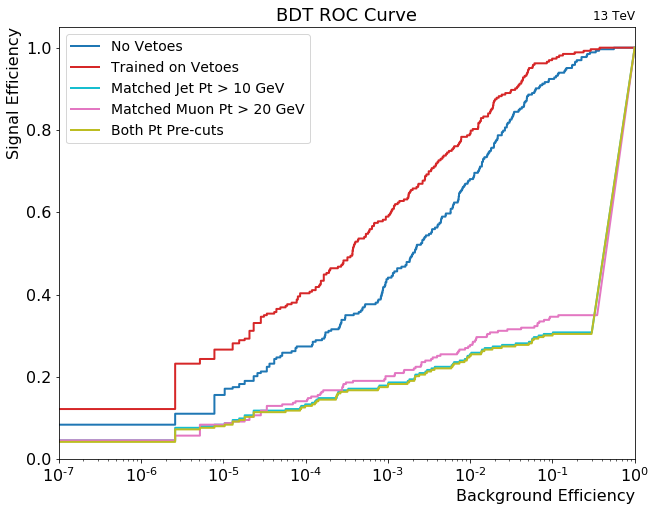

In [69]:
#plot roc curve
# fpr = Signal eff, tpr = background eff
f = plt.figure(figsize=(10,8))
ax = f.add_subplot(111)
ax.set_xscale('log')
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
lw = 2
plt.plot(fpr_data, tpr_data, color='tab:blue',
         lw=lw, label='ggH vs. Data')

# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
plt.xlim([10**-7, 10**0])
plt.ylim([0.0, 1.05])
plt.ylabel('Signal Efficiency',horizontalalignment='right', y=1.0, fontsize=16)
plt.xlabel('Background Efficiency',horizontalalignment='right', x=1.0, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.axhline(y=0.9, color="black", linestyle='--')
# plt.axhline(y=0.8, color="black")
# plt.text(10**-4.5,0.3,'WP80: bkg eff = %.4f'%WP80_effBkg, fontsize=12)
# plt.text(10**-4.5,0.2,'WP90: bkg eff = %.4f'%WP90_effBkg, fontsize=12)
#plt.text(0.5,0.3,'WP90: S/sqrt(B) = %.2f'%WP90_significance, fontsize=12)
# plt.text(10**-4.5,0.4,'AUC = %.4f'%AUC, fontsize=12)
plt.title('BDT ROC Curve', fontsize=18)
plt.legend(loc="upper left", fontsize=14)
#plt.show()
# plt.text(0.0, 1.01, "CMS", ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
# plt.text(0.12, 1.01, "Simulation Preliminary", ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
plt.text(1.0, 1.01, "13 TeV", ha='right', va='bottom', transform=ax.transAxes, fontsize=12)
plt.savefig(plotDir+'training/myroc_' + test_name + '.pdf')
plt.savefig(plotDir+'training/myroc_' + test_name + '.png')
plt.savefig(plotDir+'training/myroc_' + test_name + '.eps')
os.system("chmod 755 "+plotDir+"training/*")

In [227]:
# Extracts nCsc rechits for each training type

def ncsc_extractor(cluster_sizes, cluster_counts, discriminator):
    cluster_counter = 0
    ncsc_before = []
    ncsc_after = []
    for event in cluster_counts:
        ncsc_event_before = 0
        ncsc_event_after = 0
        for cluster in range(event):
            ncsc_event_before += cluster_sizes[cluster_counter]
            if discriminator[cluster_counter] > 0.0050625005:
                ncsc_event_after += cluster_sizes[cluster_counter]
            cluster_counter += 1
        ncsc_before.append(ncsc_event_before)
        ncsc_after.append(ncsc_event_after)
    return np.array(ncsc_before), np.array(ncsc_after)

In [229]:
ncsc_signal_old_before, ncsc_signal_old_after = ncsc_extractor(size_signal['cscRechitClusterSize'].to_numpy(), count_signal['nCscRechitClusters'].to_numpy(), disc_signal_old, gen_matching_np)
ncsc_signal_normal_before, ncsc_signal_normal_after = ncsc_extractor(size_signal['cscRechitClusterSize'].to_numpy(), count_signal['nCscRechitClusters'].to_numpy(), disc_signal_normal, gen_matching_np)

ncsc_bkg_old_before, ncsc_bkg_old_after = ncsc_extractor(size_bkg['cscRechitClusterSize'].to_numpy(), count_bkg['nCscRechitClusters'].to_numpy(), disc_bkg_old)
ncsc_bkg_normal_before, ncsc_bkg_normal_after = ncsc_extractor(size_bkg['cscRechitClusterSize'].to_numpy(), count_bkg['nCscRechitClusters'].to_numpy(), disc_bkg_normal)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


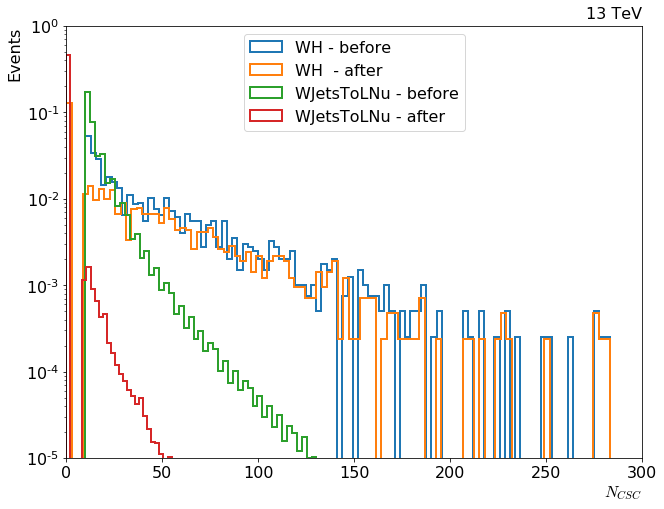

In [232]:
##########################################################
# make histogram of ncsc before and after BDT
##########################################################

f = plt.figure(figsize=(10,8))
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
# plt.hist(np.array(ncsc_signal).flatten(), bins=150, alpha=1.0, histtype="step", lw=2,)
plt.hist(ncsc_signal_old_before, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="ggH - before")
plt.hist(ncsc_signal_old_after, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="ggH  - after")
plt.hist(ncsc_bkg_old_before, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="Data - before")
plt.hist(ncsc_bkg_old_after, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="Data - after")
plt.yscale("log")
plt.xlim([0.0, 500])
plt.ylim([10**-5, 1])
plt.legend(loc="upper center", fontsize=16)
plt.xlabel('$N_{rechits}$',horizontalalignment='right', x=1.0, fontsize=16)
plt.ylabel('Events',horizontalalignment='right', y=1.0, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.axvline(x=WP90_threshold, color="black", linestyle='--')
# plt.axvline(x=WP80_threshold, color="black")
# plt.text(0.84,0.9,'WP90: disc > %.4f'%WP90_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.text(0.84,0.8,'WP80: disc > %.4f'%WP80_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.text(0.0, 1.01, "CMS", ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
# plt.text(0.12, 1.01, "Simulation Preliminary", ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
plt.text(1.0, 1.01, "13 TeV", ha='right', va='bottom', transform=ax.transAxes, fontsize=16)
plt.savefig(plotDir+'training/mydiscriminator_' + test_name +'_logY.pdf')
plt.savefig(plotDir+'training/mydiscriminator_' + test_name +'_logY.png')
plt.savefig(plotDir+'training/mydiscriminator_' + test_name +'_logY.eps')

In [170]:
os.system("chmod 755 "+plotDir+"training/*")

0

In [24]:
time_signal_spread = []
for elementS in np.array(df_signal['cscClusterTimeSpread']):
    time_signal_spread.append(elementS[0])
    
time_bkg_spread = []
for elementB in np.array(df_bkg['cscClusterTimeSpread']):
    time_bkg_spread.append(elementB[0])
    
phi_signal_spread = []
for elementS in np.array(df_signal['cscClusterPhiSpread']):
    phi_signal_spread.append(elementS[0])
    
phi_bkg_spread = []
for elementB in np.array(df_bkg['cscClusterPhiSpread']):
    phi_bkg_spread.append(elementB[0])
    
eta_signal_spread = []
for elementS in np.array(df_signal['cscClusterEtaSpread']):
    eta_signal_spread.append(elementS[0])
    
eta_bkg_spread = []
for elementB in np.array(df_bkg['cscClusterEtaSpread']):
    eta_bkg_spread.append(elementB[0])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


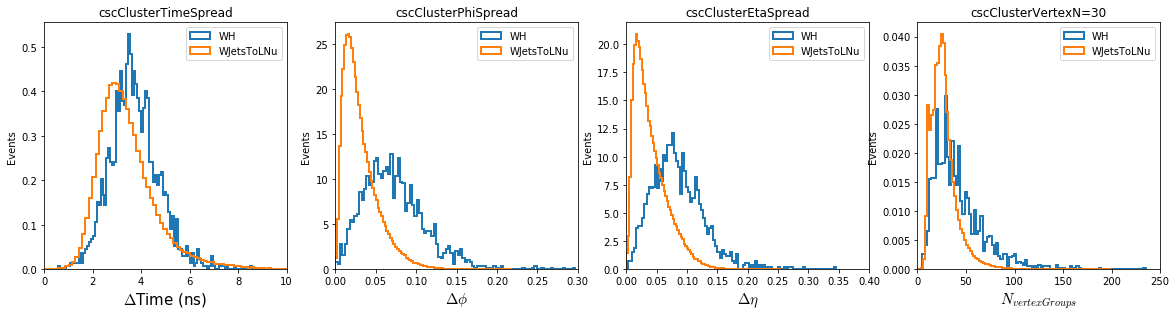

In [35]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(20, 10))
G = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(G[0, 0])
ax2 = plt.subplot(G[0, 1])
ax3 = plt.subplot(G[0, 2])
ax4 = plt.subplot(G[0, 3])

ax1.hist(time_signal_spread, density=True, alpha=1.0, histtype="step", lw=2, bins=100, label='WH')
ax1.hist(time_bkg_spread, density=True, alpha=1.0, histtype="step", lw=2, bins=100, label='WJetsToLNu')
ax1.set_xlim(0,10)
ax1.legend(loc="upper right", fontsize = 10)
ax1.set_xlabel('$\Delta$Time (ns)', fontsize = 15)
ax1.set_ylabel('Events')
ax1.set_title('cscClusterTimeSpread')

ax2.hist(phi_signal_spread, density=True, alpha=1.0, histtype="step", lw=2, bins=100, label='WH')
ax2.hist(phi_bkg_spread, density=True, alpha=1.0, histtype="step", lw=2, bins=100, label='WJetsToLNu')
ax2.set_xlim(0,0.3)
ax2.legend(loc="upper right", fontsize = 10)
ax2.set_xlabel('$\Delta\phi$', fontsize = 15)
ax2.set_ylabel('Events')
ax2.set_title('cscClusterPhiSpread')

ax3.hist(eta_signal_spread, density=True, alpha=1.0, histtype="step", lw=2, bins=100, label='WH')
ax3.hist(eta_bkg_spread, density=True, alpha=1.0, histtype="step", lw=2, bins=100, label='WJetsToLNu')
ax3.set_xlim(0,0.4)
ax3.legend(loc="upper right", fontsize = 10)
ax3.set_xlabel('$\Delta\eta$', fontsize = 15)
ax3.set_ylabel('Events')
ax3.set_title('cscClusterEtaSpread')

ax4.hist(nV_signal_spread, density=True, alpha=1.0, histtype="step", lw=2, bins=100, label='WH')
ax4.hist(nV_bkg_spread, density=True, alpha=1.0, histtype="step", lw=2, bins=100, label='WJetsToLNu')
ax4.set_xlim(0,250)
ax4.legend(loc="upper right", fontsize = 10)
ax4.set_xlabel('$N_{vertexGroups}$', fontsize = 15)
ax4.set_ylabel('Events')
ax4.set_title('cscClusterVertexN=30')

plt.draw()
plt.savefig(plotDir+'variables/'+test_name + '_grid_plot'+'.pdf')#, bbox_inches='tight')
plt.savefig(plotDir+'variables/'+test_name + '_grid_plot'+'.png')#, bbox_inches='tight')
plt.savefig(plotDir+'variables/'+test_name + '_grid_plot'+'.eps')#, bbox_inches='tight')